<a href="https://colab.research.google.com/github/rag09reddy/Caspar_ML/blob/main/tf_gradient_boost_trees_with_BF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing required libraries

!pip install tensorflow_decision_forests

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras as ks

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

# Load TF-DF
import tensorflow_decision_forests as tfdf
import pandas as pd

from itertools import product




# 1. Data Collection and data pre-processing

1. Converting the Data set into the form of input for individual speed and pressure values.
2. Including the "0", need to look to do for simultion which have crashed case. Need to do something for the missing data.

In [ ]:
# Provide the path to your Excel file
excel_file_path = "/content/ML_input_data_March_2_without_BF%.txt"

# Read the Excel file into a DataFrame
train_df = pd.read_csv(excel_file_path,'\t')

# Dropping the unessary rows and columns.
train_df = train_df.drop(labels = ["DesignID"],axis =1)
columns_to_drop = ['Leakge_1800rpm_300dp', 'Leakge_1800rpm_100dp', 'Leakge_500rpm_300dp', 'Leakge_500rpm_100dp','Ploss_L_W_1800rpm_300dp','Ploss_F_W_1800rpm_300dp','Ploss_L_W_1800rpm_100dp','Ploss_F_W_1800rpm_100dp','Ploss_L_W_500rpm_300dp','Ploss_F_W_500rpm_300dp','Ploss_L_W_500rpm_100dp','Ploss_F_W_500rpm_100dp']
train_df.drop(columns=columns_to_drop, inplace=True)


# Manually specified speed and pressure values
speed_values = [1800, 500]
pressure_values = [100, 300]

# Generate combinations of speed and pressure for each row
combinations = list(product(speed_values, pressure_values))

# Create a new DataFrame with all combinations
expanded_df = pd.DataFrame(list(product(train_df.index, combinations)), columns=['original_index', 'speed_pressure'])

# Split the speed and pressure values into separate columns
expanded_df[['speed', 'pressure']] = pd.DataFrame(expanded_df['speed_pressure'].tolist(), index=expanded_df.index)

# Merge with the original DataFrame
result_df = pd.merge(expanded_df, train_df, left_on='original_index', right_index=True)


# Explicitly select the required columns

# Load values in P_loss column based on conditions
result_df['P_loss'] = result_df.apply(lambda row:
                                      row[f'Ploss_W_{row["speed"]}rpm_{row["pressure"]}dp']
                                      if (f'Ploss_W_{row["speed"]}rpm_{row["pressure"]}dp' in row.index)
                                      else None, axis=1)

# Reorder columns as needed
result_df = result_df[['Frequency', 'Amplitude', 'Offset','InnRing','OutRing','speed', 'pressure','P_loss']]

# Print the modified DataFrame
print(result_df)



      Frequency  Amplitude  Offset  InnRing  OutRing  speed  pressure  \
0             0          0       0      0.0      0.0   1800       100   
1             0          0       0      0.0      0.0   1800       300   
2             0          0       0      0.0      0.0    500       100   
3             0          0       0      0.0      0.0    500       300   
4            12          1    -105      0.0      0.0   1800       100   
...         ...        ...     ...      ...      ...    ...       ...   
1003          0          0       0     -1.0     -1.5    500       300   
1004          0          0       0     -1.0     -1.0   1800       100   
1005          0          0       0     -1.0     -1.0   1800       300   
1006          0          0       0     -1.0     -1.0    500       100   
1007          0          0       0     -1.0     -1.0    500       300   

           P_loss  
0     1032.026237  
1     1535.308859  
2      187.756865  
3      466.186770  
4      964.906512  
...

<ipython-input-104-9304f20acc70>:5: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  train_df = pd.read_csv(excel_file_path,'\t')


In [ ]:
train_df = result_df

In [ ]:
train_df.head()

,Frequency,Amplitude,Offset,InnRing,OutRing,speed,pressure,P_loss
0,0,0,0,0.0,0.0,1800,100,1032.026237
1,0,0,0,0.0,0.0,1800,300,1535.308859
2,0,0,0,0.0,0.0,500,100,187.756865
3,0,0,0,0.0,0.0,500,300,466.186770
4,12,1,-105,0.0,0.0,1800,100,964.906512


3.  Data Cleaning: Before traning the Data removing 0 values and trying

In [ ]:
# Columns to check for 0 values
columns_to_check = ['P_loss']

# Create a copy of rows where 'P_loss' is 0 or NaN
# Drop the 'P_loss' column from zero_df

zero_df = train_df[train_df['P_loss'].isna() | (train_df['P_loss'] == 0)].copy()
zero_df.drop('P_loss', axis=1, inplace=True)

# Filter rows where any of the specified columns has a value of 0
train_df = train_df.dropna().loc[(train_df[columns_to_check] != 0).all(axis=1)]

# Resetting the index after removing rows
train_df.reset_index(drop=True, inplace=True)

print(train_df.shape)

data = train_df

(960, 8)


In [ ]:
#zero_df.head(40)

4. Training and validation split

In [ ]:
#Test train split
import numpy as np

def split_dataset(dataset, test_ratio=0.2):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_df_pd, valid_df_pd = split_dataset(train_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_df_pd), len(valid_df_pd)))

771 examples in training, 189 examples in testing.


5. Setting the Target Column


In [ ]:
# Importing the Tensor Flow decision tree model
label = 'P_loss'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df_pd, label=label, task = tfdf.keras.Task.REGRESSION)

# 2. Importing the ML model and Training the Model without any hyper-paramters OPtimisers

1. Here we are using the Auto trained TF Keras Gradient Boosted Trees Model to train the ML model



In [ ]:

rf = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION, num_trees = 100)


Use /tmp/tmpv7cwqdym as temporary training directory


In [ ]:

rf.compile(optimizer='adam', loss='mse', metrics=['mse'])


In [ ]:
# Train the model and collect training logs
val_logs   = rf.fit(
    x = train_ds,
    validation_data=valid_ds,
    verbose=0
).history

Num validation examples: tf.Tensor(189, shape=(), dtype=int32)


# 3. Evaluating the model on the validation set and by measuring the RMSE validation losses.

In [ ]:
# Evalauting the model with vadilation data set
inspector = rf.make_inspector()
inspector.evaluation()
evaluation = rf.evaluate(x=valid_ds,return_dict=True)
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 650ms/step - loss: 9075.5098 - mse: 9075.5098
loss: 9075.5098
mse: 9075.5098


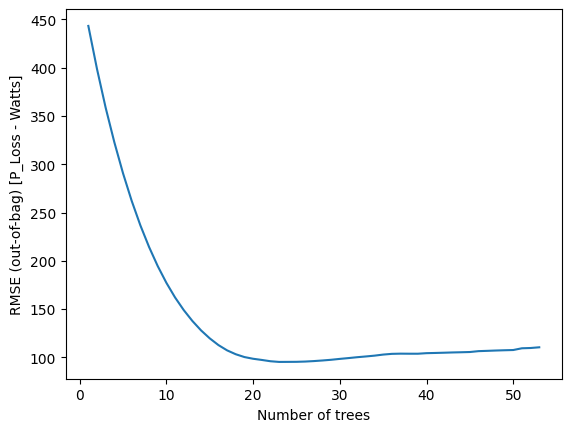

Evaluation(num_examples=None, accuracy=None, loss=95.26547241210938, rmse=95.26547241210938, ndcg=None, aucs=None, auuc=None, qini=None)


In [ ]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
val_logs = rf.make_inspector().evaluation()

plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag) [P_Loss - Watts]")
plt.show()
print(val_logs)

1/1 [==============================] - 0s 131ms/step


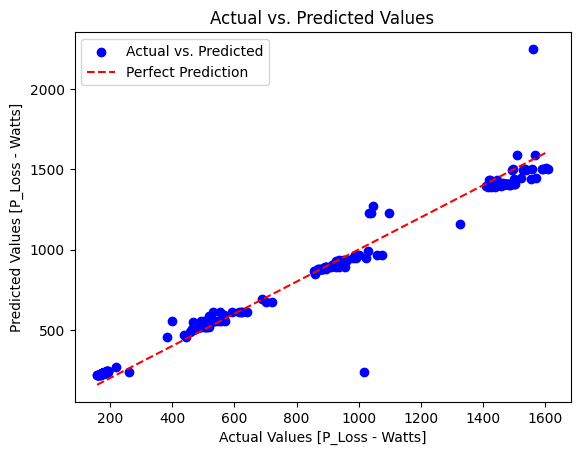

In [ ]:
# Plot actual vs. predicted values on the validation set
validation_predictions = rf.predict(valid_ds)
actual_values = valid_df_pd['P_loss'].values

# Plot actual vs. predicted values with different markers
plt.scatter(actual_values, validation_predictions, label='Actual vs. Predicted', marker='o', color='blue')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], linestyle='--', color='red', label='Perfect Prediction')
plt.xlabel('Actual Values [P_Loss - Watts]')
plt.ylabel('Predicted Values [P_Loss - Watts]')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

# Deplyoing the Model i.e Testing the Model for Larger Data Set

In [ ]:

peaks_values = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]  # Frequencz
amplitude_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
phase_shift_values = [-180, -140, -120, -100,  -80, -60,  -40,  -20, -10, 0, 180, 160, 140,  120,  100,  80,  60,  40,  20, 10]  # offset
InnRing_values = [-2.5,-2,-1.5,-1,-0.5,0,0.5,1]
OutRing_values = [-2.5,-2,-1.5,-1,-0.5,0,0.5,1]


speed_values = [1800, 500]  # Speed
pressure_values = [300, 100]  # Pressure

data = []
for p in peaks_values:
    for a in amplitude_values:
        for s in phase_shift_values:
            for i in InnRing_values:
                for o in OutRing_values:
                    for sp in speed_values:
                        for pr in pressure_values:
                            data.append([p, a, s, i, o, sp, pr])

test_df_big = pd.DataFrame(data, columns=['Frequency', 'Amplitude', 'Offset', 'InnRing', 'OutRing', 'speed', 'pressure'])

print(test_df_big)

         Frequency  Amplitude  Offset  InnRing  OutRing  speed  pressure
0                4          1    -180     -2.5     -2.5   1800       300
1                4          1    -180     -2.5     -2.5   1800       100
2                4          1    -180     -2.5     -2.5    500       300
3                4          1    -180     -2.5     -2.5    500       100
4                4          1    -180     -2.5     -2.0   1800       300
...            ...        ...     ...      ...      ...    ...       ...
1023995         23         10      10      1.0      0.5    500       100
1023996         23         10      10      1.0      1.0   1800       300
1023997         23         10      10      1.0      1.0   1800       100
1023998         23         10      10      1.0      1.0    500       300
1023999         23         10      10      1.0      1.0    500       100

[1024000 rows x 7 columns]


1. Creating the TF Data-set. (i.e Converitng the data according tot the TF data frame)

In [ ]:
# Create a TF-DF dataset from the test DataFrame
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df_big, task=tfdf.keras.Task.REGRESSION)

2. Prediction for the larger data set.

In [ ]:

# Predict P_loss values on the test dataset
pred_large_ds = rf.predict(test_ds)

# Extract the predicted P_loss values
predicted_ploss = pred_large_ds

# Print the predicted P_loss values
print(predicted_ploss)


1024/1024 [==============================] - 18s 18ms/step
[[1398.2003 ]
 [1050.0695 ]
 [ 558.99023]
 ...
 [1241.9584 ]
 [1259.4108 ]
 [ 685.134  ]]


3. Flattern the predicted_ploss to add to the larger data set.

In [ ]:
# Assuming 'predicted_ploss' is the predicted values array
predicted_ploss = predicted_ploss.flatten()

# Add new columns to the DataFrame
test_df_big['Predicted_P_loss'] = predicted_ploss



In [ ]:
print(test_df_big)

         Frequency  Amplitude  Offset  InnRing  OutRing  speed  pressure  \
0                4          1    -180     -2.5     -2.5   1800       300   
1                4          1    -180     -2.5     -2.5   1800       100   
2                4          1    -180     -2.5     -2.5    500       300   
3                4          1    -180     -2.5     -2.5    500       100   
4                4          1    -180     -2.5     -2.0   1800       300   
...            ...        ...     ...      ...      ...    ...       ...   
1023995         23         10      10      1.0      0.5    500       100   
1023996         23         10      10      1.0      1.0   1800       300   
1023997         23         10      10      1.0      1.0   1800       100   
1023998         23         10      10      1.0      1.0    500       300   
1023999         23         10      10      1.0      1.0    500       100   

         Predicted_P_loss  
0             1398.200317  
1             1050.069458  
2  

4. Dividing the data sets into 4 different data sets based on their speed and pressure combinations

In [ ]:
# Create new data sets based on conditions
test_df_big_s1800_p300 = test_df_big[(test_df_big['speed'] == 1800) & (test_df_big['pressure'] == 300)]
test_df_big_s1800_p100 = test_df_big[(test_df_big['speed'] == 1800) & (test_df_big['pressure'] == 100)]
test_df_big_s500_p300 = test_df_big[(test_df_big['speed'] == 500) & (test_df_big['pressure'] == 300)]
test_df_big_s500_p100 = test_df_big[(test_df_big['speed'] == 500) & (test_df_big['pressure'] == 100)]

# Print or use the new data sets as needed
print("test_df_big_s1800_p300:")
print(test_df_big_s1800_p300)


test_df_big_s1800_p300:
         Frequency  Amplitude  Offset  InnRing  OutRing  speed  pressure  \
0                4          1    -180     -2.5     -2.5   1800       300   
4                4          1    -180     -2.5     -2.0   1800       300   
8                4          1    -180     -2.5     -1.5   1800       300   
12               4          1    -180     -2.5     -1.0   1800       300   
16               4          1    -180     -2.5     -0.5   1800       300   
...            ...        ...     ...      ...      ...    ...       ...   
1023980         23         10      10      1.0     -1.0   1800       300   
1023984         23         10      10      1.0     -0.5   1800       300   
1023988         23         10      10      1.0      0.0   1800       300   
1023992         23         10      10      1.0      0.5   1800       300   
1023996         23         10      10      1.0      1.0   1800       300   

         Predicted_P_loss  
0             1398.200317  
4      

5. Finaly predciting the best design parameters for indivadual Operating condtions.

In [ ]:
# Find rows with minimum values in "Predicted_P_loss" column for each dataset
min_row_s1800_p300 = test_df_big_s1800_p300.loc[test_df_big_s1800_p300['Predicted_P_loss'].idxmin()]
min_row_s1800_p100 = test_df_big_s1800_p100.loc[test_df_big_s1800_p100['Predicted_P_loss'].idxmin()]
min_row_s500_p300 = test_df_big_s500_p300.loc[test_df_big_s500_p300['Predicted_P_loss'].idxmin()]
min_row_s500_p100 = test_df_big_s500_p100.loc[test_df_big_s500_p100['Predicted_P_loss'].idxmin()]

# Print the rows with minimum values
print("Row with the minimum Predicted_P_loss in test_df_big_s1800_p300:")
print(min_row_s1800_p300)

print("\nRow with the minimum Predicted_P_loss in test_df_big_s1800_p100:")
print(min_row_s1800_p100)

print("\nRow with the minimum Predicted_P_loss in test_df_big_s500_p300:")
print(min_row_s500_p300)

print("\nRow with the minimum Predicted_P_loss in test_df_big_s500_p100:")
print(min_row_s500_p100)


Row with the minimum Predicted_P_loss in test_df_big_s1800_p300:
Frequency              8.000000
Amplitude              1.000000
Offset              -180.000000
InnRing                0.500000
OutRing               -2.500000
speed               1800.000000
pressure             300.000000
Predicted_P_loss    1345.723145
Name: 204992, dtype: float64

Row with the minimum Predicted_P_loss in test_df_big_s1800_p100:
Frequency              8.000000
Amplitude              4.000000
Offset              -180.000000
InnRing                0.500000
OutRing               -1.500000
speed               1800.000000
pressure             100.000000
Predicted_P_loss     810.052673
Name: 220361, dtype: float64

Row with the minimum Predicted_P_loss in test_df_big_s500_p300:
Frequency             4.000000
Amplitude             1.000000
Offset             -180.000000
InnRing              -1.000000
OutRing              -2.500000
speed               500.000000
pressure            300.000000
Predicted_P_loss 

6. Now looking at top 10 designs which predict the lowest P_loss, for Individual OC.

In [ ]:
# Sort datasets based on "Predicted_P_loss" column and take the first 10 rows
top_10_s1800_p300 = test_df_big_s1800_p300.sort_values(by='Predicted_P_loss').head(10)
top_10_s1800_p100 = test_df_big_s1800_p100.sort_values(by='Predicted_P_loss').head(10)
top_10_s500_p300 = test_df_big_s500_p300.sort_values(by='Predicted_P_loss').head(10)
top_10_s500_p100 = test_df_big_s500_p100.sort_values(by='Predicted_P_loss').head(10)



# Now findinag the Best design overall(i.e including all OC)

In [ ]:
import pandas as pd

# List of existing DataFrames
dfs = [test_df_big_s1800_p300, test_df_big_s1800_p100, test_df_big_s500_p300, test_df_big_s500_p100]

# Concatenate all DataFrames into one DataFrame
concatenated_df = pd.concat(dfs)

# Group by the relevant columns and sum the Predicted_P_loss
grouped_df = concatenated_df.groupby(['Frequency', 'Amplitude', 'Offset', 'InnRing', 'OutRing'])['Predicted_P_loss'].sum().reset_index()

# Create the new DataFrame with desired columns
test_df_big_T = grouped_df.copy()

# Print the row with the minimum Predicted_P_loss
print(test_df_big_T.loc[test_df_big_T['Predicted_P_loss'].idxmin()])

# Print the resulting DataFrame
print(test_df_big_T)


Frequency              8.000000
Amplitude              2.000000
Offset              -180.000000
InnRing                0.500000
OutRing               -1.500000
Predicted_P_loss    2877.518311
Name: 52530, dtype: float64
        Frequency  Amplitude  Offset  InnRing  OutRing  Predicted_P_loss
0               4          1    -180     -2.5     -2.5       3212.611328
1               4          1    -180     -2.5     -2.0       3212.611328
2               4          1    -180     -2.5     -1.5       3201.453125
3               4          1    -180     -2.5     -1.0       3204.221191
4               4          1    -180     -2.5     -0.5       3219.688232
...           ...        ...     ...      ...      ...               ...
255995         23         10     180      1.0     -1.0       3624.748535
255996         23         10     180      1.0     -0.5       3643.176514
255997         23         10     180      1.0      0.0       3651.711426
255998         23         10     180      1.0     

1. Top 10 best design for overall P_loss including all OC

In [ ]:
top_10 = test_df_big_T.sort_values(by='Predicted_P_loss').head(10)
# Print the top 10 rows with least Predicted_P_loss values

print("Top 10 rows with least Predicted_P_loss:")
print(top_10)


Top 10 rows with least Predicted_P_loss:
       Frequency  Amplitude  Offset  InnRing  OutRing  Predicted_P_loss
78394         10          2     -80      1.0     -1.5       2877.518311
52858          8          2     -60      1.0     -1.5       2877.518311
65714          9          2     -40      0.5     -1.5       2877.518311
53498          8          2     100      1.0     -1.5       2877.518311
66362          9          2     120      1.0     -1.5       2877.518311
78642         10          2     -10      0.5     -1.5       2877.518311
53490          8          2     100      0.5     -1.5       2877.518311
66226          9          2      80      0.5     -1.5       2877.518311
52914          8          2     -40      0.5     -1.5       2877.518311
78258         10          2    -120      0.5     -1.5       2877.518311


2. Top 10 worst designs

In [ ]:
top_10_highest = test_df_big_T.sort_values(by='Predicted_P_loss', ascending=False).head(10)

print("Top 10 rows with highest Predicted_P_loss:")
print(top_10_highest)

Top 10 rows with highest Predicted_P_loss:
        Frequency  Amplitude  Offset  InnRing  OutRing  Predicted_P_loss
255999         23         10     180      1.0      1.0       5194.256836
213103         20          7       0      0.0      1.0       5194.256836
213055         20          7     -10      1.0      1.0       5194.256836
213054         20          7     -10      1.0      0.5       5194.256836
213047         20          7     -10      0.5      1.0       5194.256836
213046         20          7     -10      0.5      0.5       5194.256836
213039         20          7     -10      0.0      1.0       5194.256836
213038         20          7     -10      0.0      0.5       5194.256836
212991         20          7     -20      1.0      1.0       5194.256836
212990         20          7     -20      1.0      0.5       5194.256836


# Plotting the Trend

 1. Plotting the frequency Trend for at one amplitude and Offset.

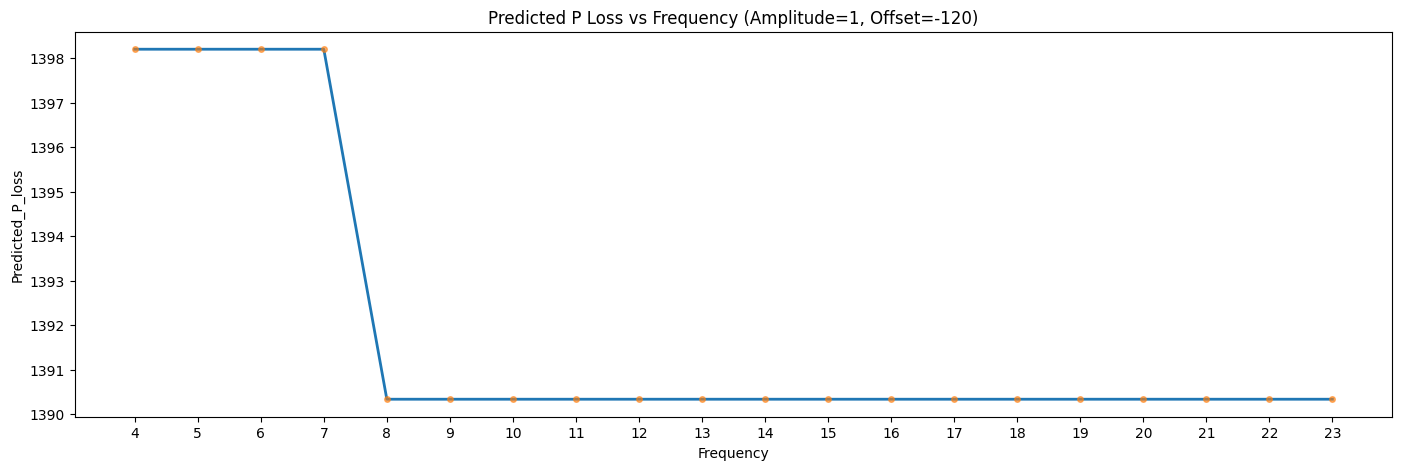

In [ ]:
import matplotlib.pyplot as plt

# Filter data for amplitude = 1 and offset = -120
filtered_data = test_df_big_T[(test_df_big_T['Amplitude'] == 2) & (test_df_big_T['Offset'] == -80)
                                       & (test_df_big_T['InnRing'] == -2.5) & (test_df_big_T['OutRing'] == -2.5)]

# Extract frequency and Predicted_P_loss values
frequency = filtered_data['Frequency'].to_numpy()
predicted_loss = filtered_data['Predicted_P_loss'].to_numpy()

# Create the plot with desired characteristics
plt.figure(figsize=(17, 5))  # Adjust figure size for a wider plot
plt.plot(frequency, predicted_loss, linewidth=2)  # Wider line
plt.plot(frequency, predicted_loss, 'o', markersize=4, alpha=0.6)  # Light dots
plt.xticks(frequency)  # Show xticks for all frequency values

# Set labels and title
plt.xlabel('Frequency')
plt.ylabel('Predicted_P_loss')
plt.title('Predicted P Loss vs Frequency (Amplitude=1, Offset=-120)')

# Show the plot
plt.show()


2. (Frequency and Amplitude Trend) Frequcny trend at different amplitudes and single offset.

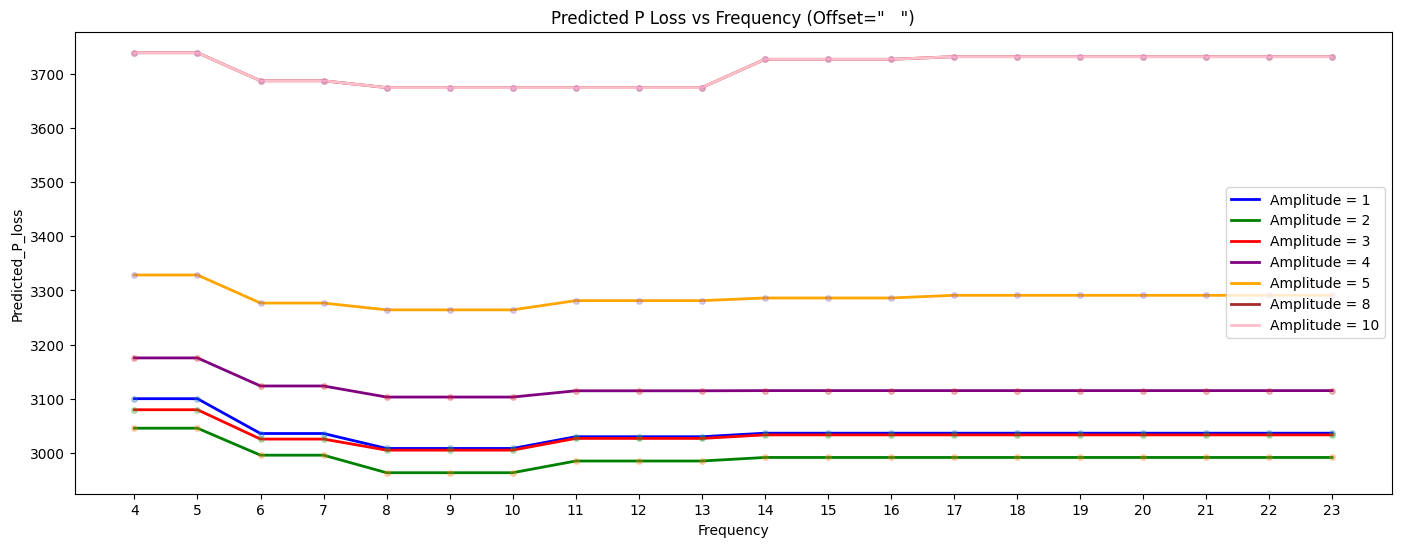

In [ ]:
import matplotlib.pyplot as plt

# Filter data for offset = -120
filtered_data = test_df_big_T[(test_df_big_T['Amplitude'].isin([1, 2, 3, 4, 5, 8, 10])) & (test_df_big_T['Offset'] == -80)
                                       & (test_df_big_T['InnRing'] == -1) & (test_df_big_T['OutRing'] == -1.5)]

# Group data by amplitude
grouped_data = filtered_data.groupby('Amplitude')

# Create the plot with desired characteristics
plt.figure(figsize=(17, 6))  # Adjust figure size for a wider plot

# Define specific colors for amplitudes 1 to 10
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

# Iterate through each group and plot with corresponding colors
for i, (amplitude, group_data) in enumerate(grouped_data):
    frequency = group_data['Frequency'].to_numpy()
    predicted_loss = group_data['Predicted_P_loss'].to_numpy()
    plt.plot(frequency, predicted_loss, label=f'Amplitude = {amplitude}', color=colors[i], linewidth=2)
    plt.plot(frequency, predicted_loss, 'o', markersize=4, alpha=0.3)

# Lighter markers for all lines

# Set labels, title, and xticks
plt.xlabel('Frequency')
plt.ylabel('Predicted_P_loss')
plt.title('Predicted P Loss vs Frequency (Offset="   ")')
plt.xticks(frequency)
plt.legend()

# Show the plot
plt.show()


3. (Frequncy and Offset trend) Frequncy trend at different offset, at single amplitude.

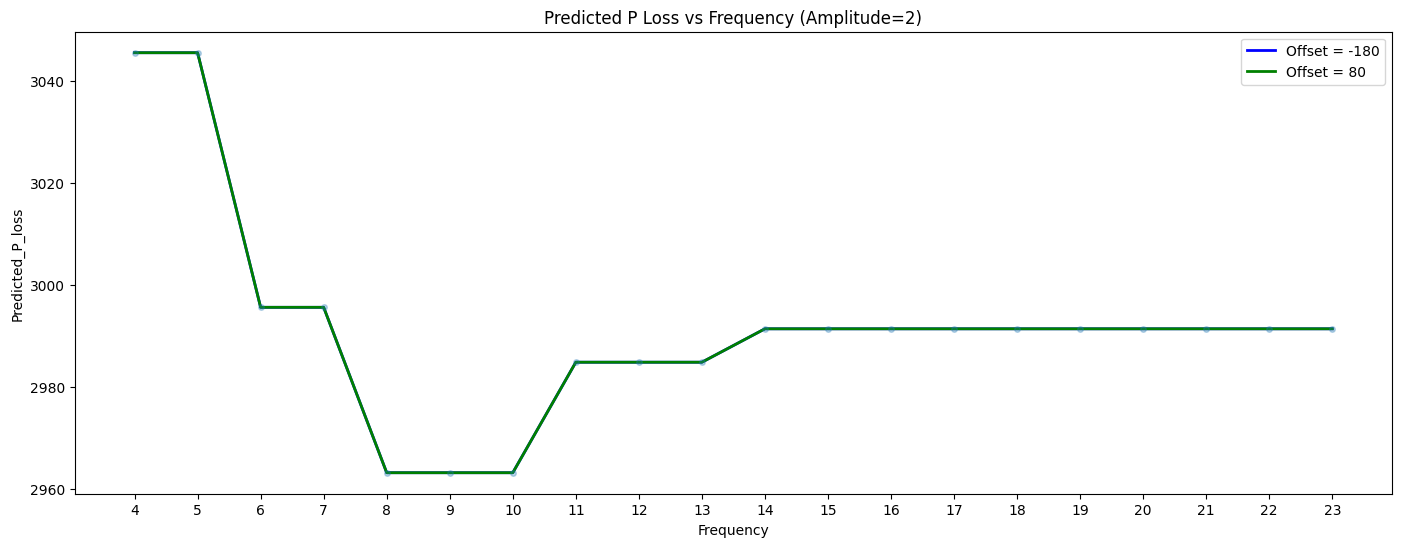

In [ ]:
import matplotlib.pyplot as plt

# Filter data for amplitude = 2 and desired offsets
filtered_data = test_df_big_T[(test_df_big_T['Amplitude'] == 2) & (test_df_big_T['Offset'].isin([-180,80]))
                                                               & (test_df_big_T['InnRing'] == -1) & (test_df_big_T['OutRing'] == -1.5)]

# Group data by offset
grouped_data = filtered_data.groupby('Offset')

# Create the plot with desired characteristics
plt.figure(figsize=(17, 6))  # Adjust figure size as needed

# Define colors for the specific offsets (optionally use a colormap)
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray']

# Iterate through each offset group and plot with corresponding colors
for i, (offset, group_data) in enumerate(grouped_data):
    frequency = group_data['Frequency'].to_numpy()
    predicted_loss = group_data['Predicted_P_loss'].to_numpy()
    plt.plot(frequency, predicted_loss, label=f'Offset = {offset}', color=colors[i], linewidth=2)

# Lighter markers for all lines
plt.plot(frequency, predicted_loss, 'o', markersize=4, alpha=0.3)

# Set labels, title, and xticks
plt.xlabel('Frequency')
plt.ylabel('Predicted_P_loss')
plt.title('Predicted P Loss vs Frequency (Amplitude=2)')
plt.xticks(frequency)
plt.legend()  # Add legend to show offset values

# Show the plot
plt.show()


# 2.1 Importing the ML model and Training the Model with  hyper-paramters OPtimiser

https://www.tensorflow.org/decision_forests/tutorials/automatic_tuning_colab#training_a_model_with_automated_hyper-parameter_tuning_and_automatic_definition_of_the_hyper-parameters_recommended_approach


*  Training a model with automated hyper-parameter tuning and automatic definition of the hyper-parameters (recommended approach)


*   As before, hyper-parameter tuning is enabled by specifying the tuner constructor argument of the model. Set use_predefined_hps=True to automatically configure the search space for the hyper-parameters.


*   Note: The automatic hyper-parameter configuration explores some powerful but slow to train hyper-parameters. For example, oblique splits (commented/disabled in the previous section; see SPARSE_OBLIQUE) are tested. This mean the tuning will be slower, but hopefully give a result of significantly higher quality.


*   A learning algorithm trains a machine learning model on a training dataset. The parameters of a learning algorithm–called "hyper-parameters"–control how the model is trained and impact its quality. Therefore, finding the best hyper-parameters is an important stage of modeling. Some hyper-parameters are simple to configure. For example, increasing the number of trees (num_trees) in a random forest increases the quality of the model until a plateau. Therefore, setting the largest value compatible with the serving constraints (more trees means a larger model) is a valid rule of thumb. However, other hyper-parameters have a more complex interaction with the model and cannot be chosen with such a simple rule. For example, increasing the maximum tree depth (max_depth) of a gradient boosted tree model can both increase or decrease the quality of the model. Furthermore, hyper-parameters can interact between each others, and the optimal value of a hyper-parameter cannot be found in isolation.





1. Here we are using the Auto trained TF Keras Gradient Boosted Trees Model to train the ML model



In [ ]:
!pip install wurlitzer -U -qq

In [ ]:
# Create a Random Search tuner with 50 trials and automatic hp configuration.
tuner = tfdf.tuner.RandomSearch(num_trials=50, use_predefined_hps=True)

In [ ]:

rf = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION, tuner=tuner, num_trees = 100)


Use /tmp/tmpnqow17if as temporary training directory


In [ ]:

rf.compile(optimizer='adam', loss='mse', metrics=['mse'])


In [ ]:
# Train the model and collect training logs
val_logs   = rf.fit(
    x = train_ds,
    validation_data=valid_ds,
    verbose=0
).history

Num validation examples: tf.Tensor(189, shape=(), dtype=int32)


# 3. Evaluating the model on the validation set and by measuring the RMSE validation losses.

In [ ]:
# Evalauting the model with vadilation data set
inspector = rf.make_inspector()
inspector.evaluation()
evaluation = rf.evaluate(x=valid_ds,return_dict=True)
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 998ms/step - loss: 2692.6387 - mse: 2692.6387
loss: 2692.6387
mse: 2692.6387


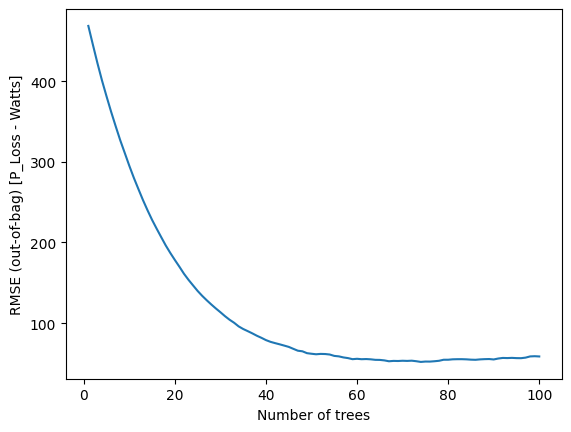

Evaluation(num_examples=None, accuracy=None, loss=51.8906364440918, rmse=51.8906364440918, ndcg=None, aucs=None, auuc=None, qini=None)


In [ ]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
val_logs = rf.make_inspector().evaluation()

plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag) [P_Loss - Watts]")
plt.show()
print(val_logs)

In [ ]:
# Display the tuning logs.
tuning_logs = rf.make_inspector().tuning_logs()
tuning_logs.head()

,score,evaluation_time,best,split_axis,sparse_oblique_projection_density_factor,sparse_oblique_normalization,sparse_oblique_weights,categorical_algorithm,growing_strategy,max_num_nodes,sampling_method,subsample,shrinkage,min_examples,num_candidate_attributes_ratio,max_depth
0,-59.814884,1.824805,False,SPARSE_OBLIQUE,5.0,MIN_MAX,BINARY,CART,BEST_FIRST_GLOBAL,32.0,RANDOM,1.0,0.10,10,1.0,NaN
1,-88.154671,3.600012,False,SPARSE_OBLIQUE,4.0,NONE,BINARY,CART,BEST_FIRST_GLOBAL,512.0,RANDOM,1.0,0.05,5,0.9,NaN
2,-81.602371,6.597592,False,SPARSE_OBLIQUE,4.0,STANDARD_DEVIATION,BINARY,CART,LOCAL,NaN,RANDOM,1.0,0.02,20,1.0,8.0
3,-68.396034,7.721124,False,SPARSE_OBLIQUE,4.0,STANDARD_DEVIATION,CONTINUOUS,CART,LOCAL,NaN,RANDOM,0.8,0.05,7,1.0,3.0
4,-57.074856,8.884445,False,SPARSE_OBLIQUE,5.0,MIN_MAX,BINARY,RANDOM,BEST_FIRST_GLOBAL,64.0,RANDOM,0.9,0.10,20,0.2,NaN


In [ ]:
# Best hyper-parameters.
tuning_logs[tuning_logs.best].iloc[0]

score                                              -51.890636
evaluation_time                                      13.56249
best                                                     True
split_axis                                     SPARSE_OBLIQUE
sparse_oblique_projection_density_factor                  2.0
sparse_oblique_normalization                          MIN_MAX
sparse_oblique_weights                                 BINARY
categorical_algorithm                                  RANDOM
growing_strategy                            BEST_FIRST_GLOBAL
max_num_nodes                                           512.0
sampling_method                                        RANDOM
subsample                                                 0.6
shrinkage                                                0.05
min_examples                                                7
num_candidate_attributes_ratio                            0.9
max_depth                                                 NaN
Name: 8,

1/1 [==============================] - 0s 133ms/step


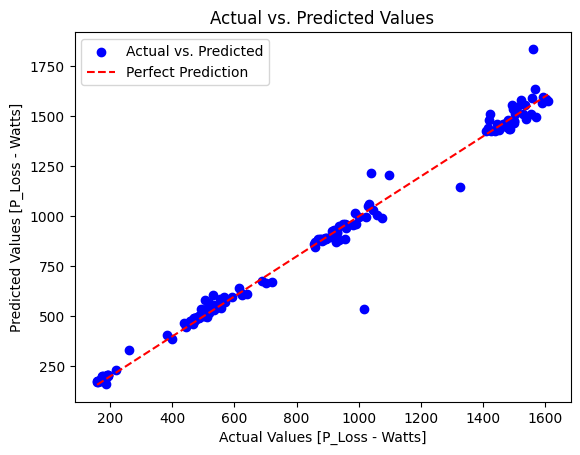

In [ ]:
# Plot actual vs. predicted values on the validation set
validation_predictions = rf.predict(valid_ds)
actual_values = valid_df_pd['P_loss'].values

# Plot actual vs. predicted values with different markers
plt.scatter(actual_values, validation_predictions, label='Actual vs. Predicted', marker='o', color='blue')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], linestyle='--', color='red', label='Perfect Prediction')
plt.xlabel('Actual Values [P_Loss - Watts]')
plt.ylabel('Predicted Values [P_Loss - Watts]')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

# Deplyoing the Model i.e Testing the Model for Larger Data Set

In [ ]:

peaks_values = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]  # Frequencz
amplitude_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
phase_shift_values = [-180, -140, -120, -100,  -80, -60,  -40,  -20, -10, 0, 180, 160, 140,  120,  100,  80,  60,  40,  20, 10]  # offset
InnRing_values = [-2.5,-2,-1.5,-1,-0.5,0,0.5,1]
OutRing_values = [-2.5,-2,-1.5,-1,-0.5,0,0.5,1]


speed_values = [1800, 500]  # Speed
pressure_values = [300, 100]  # Pressure

data = []
for p in peaks_values:
    for a in amplitude_values:
        for s in phase_shift_values:
            for i in InnRing_values:
                for o in OutRing_values:
                    for sp in speed_values:
                        for pr in pressure_values:
                            data.append([p, a, s, i, o, sp, pr])

test_df_big = pd.DataFrame(data, columns=['Frequency', 'Amplitude', 'Offset', 'InnRing', 'OutRing', 'speed', 'pressure'])

print(test_df_big)

         Frequency  Amplitude  Offset  InnRing  OutRing  speed  pressure
0                4          1    -180     -2.5     -2.5   1800       300
1                4          1    -180     -2.5     -2.5   1800       100
2                4          1    -180     -2.5     -2.5    500       300
3                4          1    -180     -2.5     -2.5    500       100
4                4          1    -180     -2.5     -2.0   1800       300
...            ...        ...     ...      ...      ...    ...       ...
1023995         23         10      10      1.0      0.5    500       100
1023996         23         10      10      1.0      1.0   1800       300
1023997         23         10      10      1.0      1.0   1800       100
1023998         23         10      10      1.0      1.0    500       300
1023999         23         10      10      1.0      1.0    500       100

[1024000 rows x 7 columns]


1. Creating the TF Data-set. (i.e Converitng the data according tot the TF data frame)

In [ ]:
# Create a TF-DF dataset from the test DataFrame
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df_big, task=tfdf.keras.Task.REGRESSION)

2. Prediction for the larger data set.

In [ ]:

# Predict P_loss values on the test dataset
pred_large_ds = rf.predict(test_ds)

# Extract the predicted P_loss values
predicted_ploss = pred_large_ds

# Print the predicted P_loss values
print(predicted_ploss)


1024/1024 [==============================] - 14s 13ms/step
[[1537.3622 ]
 [1149.7617 ]
 [ 563.2678 ]
 ...
 [1300.2843 ]
 [1234.4949 ]
 [ 641.76373]]


3. Flattern the predicted_ploss to add to the larger data set.

In [ ]:
# Assuming 'predicted_ploss' is the predicted values array
predicted_ploss = predicted_ploss.flatten()

# Add new columns to the DataFrame
test_df_big['Predicted_P_loss'] = predicted_ploss



In [ ]:
print(test_df_big)

         Frequency  Amplitude  Offset  InnRing  OutRing  speed  pressure  \
0                4          1    -180     -2.5     -2.5   1800       300   
1                4          1    -180     -2.5     -2.5   1800       100   
2                4          1    -180     -2.5     -2.5    500       300   
3                4          1    -180     -2.5     -2.5    500       100   
4                4          1    -180     -2.5     -2.0   1800       300   
...            ...        ...     ...      ...      ...    ...       ...   
1023995         23         10      10      1.0      0.5    500       100   
1023996         23         10      10      1.0      1.0   1800       300   
1023997         23         10      10      1.0      1.0   1800       100   
1023998         23         10      10      1.0      1.0    500       300   
1023999         23         10      10      1.0      1.0    500       100   

         Predicted_P_loss  
0             1537.362183  
1             1149.761719  
2  

4. Dividing the data sets into 4 different data sets based on their speed and pressure combinations

In [ ]:
# Create new data sets based on conditions
test_df_big_s1800_p300 = test_df_big[(test_df_big['speed'] == 1800) & (test_df_big['pressure'] == 300)]
test_df_big_s1800_p100 = test_df_big[(test_df_big['speed'] == 1800) & (test_df_big['pressure'] == 100)]
test_df_big_s500_p300 = test_df_big[(test_df_big['speed'] == 500) & (test_df_big['pressure'] == 300)]
test_df_big_s500_p100 = test_df_big[(test_df_big['speed'] == 500) & (test_df_big['pressure'] == 100)]

# Print or use the new data sets as needed
print("test_df_big_s1800_p300:")
print(test_df_big_s1800_p300)


test_df_big_s1800_p300:
         Frequency  Amplitude  Offset  InnRing  OutRing  speed  pressure  \
0                4          1    -180     -2.5     -2.5   1800       300   
4                4          1    -180     -2.5     -2.0   1800       300   
8                4          1    -180     -2.5     -1.5   1800       300   
12               4          1    -180     -2.5     -1.0   1800       300   
16               4          1    -180     -2.5     -0.5   1800       300   
...            ...        ...     ...      ...      ...    ...       ...   
1023980         23         10      10      1.0     -1.0   1800       300   
1023984         23         10      10      1.0     -0.5   1800       300   
1023988         23         10      10      1.0      0.0   1800       300   
1023992         23         10      10      1.0      0.5   1800       300   
1023996         23         10      10      1.0      1.0   1800       300   

         Predicted_P_loss  
0             1537.362183  
4      

5. Finaly predciting the best design parameters for indivadual Operating condtions.

In [ ]:
# Find rows with minimum values in "Predicted_P_loss" column for each dataset
min_row_s1800_p300 = test_df_big_s1800_p300.loc[test_df_big_s1800_p300['Predicted_P_loss'].idxmin()]
min_row_s1800_p100 = test_df_big_s1800_p100.loc[test_df_big_s1800_p100['Predicted_P_loss'].idxmin()]
min_row_s500_p300 = test_df_big_s500_p300.loc[test_df_big_s500_p300['Predicted_P_loss'].idxmin()]
min_row_s500_p100 = test_df_big_s500_p100.loc[test_df_big_s500_p100['Predicted_P_loss'].idxmin()]

# Print the rows with minimum values
print("Row with the minimum Predicted_P_loss in test_df_big_s1800_p300:")
print(min_row_s1800_p300)

print("\nRow with the minimum Predicted_P_loss in test_df_big_s1800_p100:")
print(min_row_s1800_p100)

print("\nRow with the minimum Predicted_P_loss in test_df_big_s500_p300:")
print(min_row_s500_p300)

print("\nRow with the minimum Predicted_P_loss in test_df_big_s500_p100:")
print(min_row_s500_p100)


Row with the minimum Predicted_P_loss in test_df_big_s1800_p300:
Frequency             23.000000
Amplitude              1.000000
Offset              -100.000000
InnRing               -0.500000
OutRing               -1.000000
speed               1800.000000
pressure             300.000000
Predicted_P_loss    1369.058594
Name: 973708, dtype: float64

Row with the minimum Predicted_P_loss in test_df_big_s1800_p100:
Frequency             11.000000
Amplitude              5.000000
Offset               -80.000000
InnRing               -0.500000
OutRing               -1.500000
speed               1800.000000
pressure             100.000000
Predicted_P_loss     819.345093
Name: 380041, dtype: float64

Row with the minimum Predicted_P_loss in test_df_big_s500_p300:
Frequency             5.000000
Amplitude             1.000000
Offset              -20.000000
InnRing              -1.500000
OutRing              -1.500000
speed               500.000000
pressure            300.000000
Predicted_P_loss 

6. Now looking at top 10 designs which predict the lowest P_loss, for Individual OC.

In [ ]:
# Sort datasets based on "Predicted_P_loss" column and take the first 10 rows
top_10_s1800_p300 = test_df_big_s1800_p300.sort_values(by='Predicted_P_loss').head(10)
top_10_s1800_p100 = test_df_big_s1800_p100.sort_values(by='Predicted_P_loss').head(10)
top_10_s500_p300 = test_df_big_s500_p300.sort_values(by='Predicted_P_loss').head(10)
top_10_s500_p100 = test_df_big_s500_p100.sort_values(by='Predicted_P_loss').head(10)



# Now findinag the Best design overall(i.e including all OC)

In [ ]:
import pandas as pd

# List of existing DataFrames
dfs = [test_df_big_s1800_p300, test_df_big_s1800_p100, test_df_big_s500_p300, test_df_big_s500_p100]

# Concatenate all DataFrames into one DataFrame
concatenated_df = pd.concat(dfs)

# Group by the relevant columns and sum the Predicted_P_loss
grouped_df = concatenated_df.groupby(['Frequency', 'Amplitude', 'Offset', 'InnRing', 'OutRing'])['Predicted_P_loss'].sum().reset_index()

# Create the new DataFrame with desired columns
test_df_big_T = grouped_df.copy()

# Print the row with the minimum Predicted_P_loss
print(test_df_big_T.loc[test_df_big_T['Predicted_P_loss'].idxmin()])

# Print the resulting DataFrame
print(test_df_big_T)


Frequency             15.000000
Amplitude              2.000000
Offset               -80.000000
InnRing               -0.500000
OutRing               -1.500000
Predicted_P_loss    2904.905273
Name: 142370, dtype: float64
        Frequency  Amplitude  Offset  InnRing  OutRing  Predicted_P_loss
0               4          1    -180     -2.5     -2.5       3499.173584
1               4          1    -180     -2.5     -2.0       3569.259766
2               4          1    -180     -2.5     -1.5       3488.817871
3               4          1    -180     -2.5     -1.0       4094.310791
4               4          1    -180     -2.5     -0.5       4223.818359
...           ...        ...     ...      ...      ...               ...
255995         23         10     180      1.0     -1.0       3641.287598
255996         23         10     180      1.0     -0.5       3699.131348
255997         23         10     180      1.0      0.0       3725.501709
255998         23         10     180      1.0    

1. Top 10 best design for overall P_loss including all OC

In [ ]:
top_10 = test_df_big_T.sort_values(by='Predicted_P_loss').head(10)
# Print the top 10 rows with least Predicted_P_loss values

print("Top 10 rows with least Predicted_P_loss:")
print(top_10)


Top 10 rows with least Predicted_P_loss:
        Frequency  Amplitude  Offset  InnRing  OutRing  Predicted_P_loss
142370         15          2     -80     -0.5     -1.5       2904.905273
129570         14          2     -80     -0.5     -1.5       2904.954346
103970         12          2     -80     -0.5     -1.5       2905.992188
142434         15          2     -60     -0.5     -1.5       2908.977295
129634         14          2     -60     -0.5     -1.5       2910.111328
116770         13          2     -80     -0.5     -1.5       2910.792480
129698         14          2     -40     -0.5     -1.5       2911.438721
142498         15          2     -40     -0.5     -1.5       2911.737793
104034         12          2     -60     -0.5     -1.5       2913.581055
116834         13          2     -60     -0.5     -1.5       2914.488770


2. Top 10 worst designs

In [ ]:
top_10_highest = test_df_big_T.sort_values(by='Predicted_P_loss', ascending=False).head(10)

print("Top 10 rows with highest Predicted_P_loss:")
print(top_10_highest)

Top 10 rows with highest Predicted_P_loss:
        Frequency  Amplitude  Offset  InnRing  OutRing  Predicted_P_loss
98543          11          7     180      0.0      1.0       5792.270020
111215         12          7     140      0.0      1.0       5787.336914
85743          10          7     180      0.0      1.0       5786.567383
72943           9          7     180      0.0      1.0       5786.487305
111343         12          7     180      0.0      1.0       5786.273926
149743         15          7     180      0.0      1.0       5781.758301
111151         12          7     120      0.0      1.0       5779.668457
98479          11          7     160      0.0      1.0       5779.260254
136943         14          7     180      0.0      1.0       5777.009766
98351          11          7     120      0.0      1.0       5776.849609


# Plotting the Trend

 1. Plotting the frequency Trend for at one amplitude and Offset.

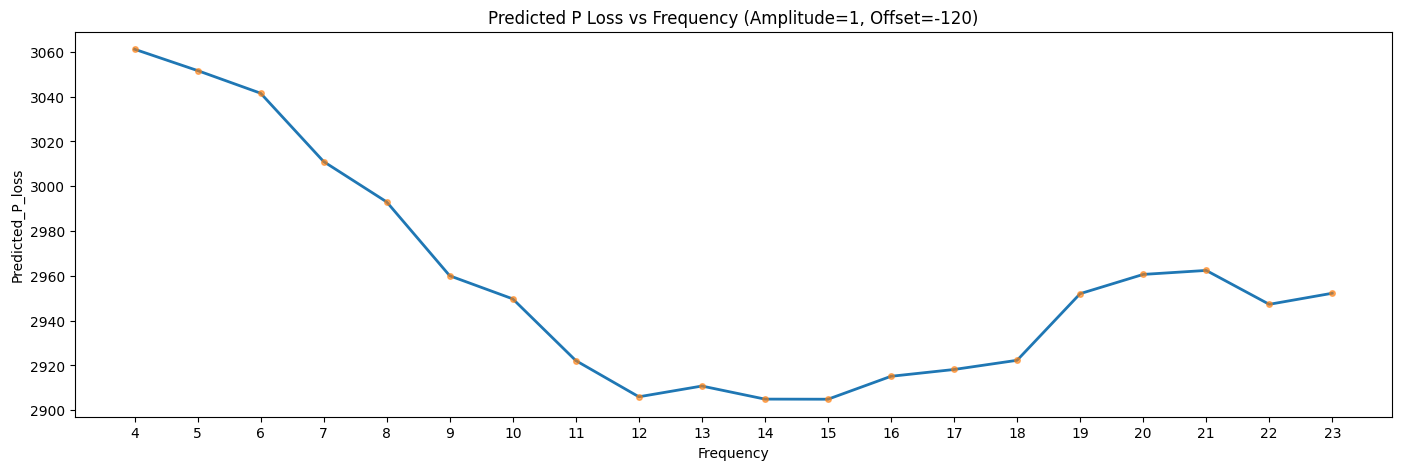

In [ ]:
import matplotlib.pyplot as plt

# Filter data for amplitude = 1 and offset = -120
filtered_data = test_df_big_T[(test_df_big_T['Amplitude'] == 2) & (test_df_big_T['Offset'] == -80)
                                       & (test_df_big_T['InnRing'] == -0.5) & (test_df_big_T['OutRing'] == -1.5)]

# Extract frequency and Predicted_P_loss values
frequency = filtered_data['Frequency'].to_numpy()
predicted_loss = filtered_data['Predicted_P_loss'].to_numpy()

# Create the plot with desired characteristics
plt.figure(figsize=(17, 5))  # Adjust figure size for a wider plot
plt.plot(frequency, predicted_loss, linewidth=2)  # Wider line
plt.plot(frequency, predicted_loss, 'o', markersize=4, alpha=0.6)  # Light dots
plt.xticks(frequency)  # Show xticks for all frequency values

# Set labels and title
plt.xlabel('Frequency')
plt.ylabel('Predicted_P_loss')
plt.title('Predicted P Loss vs Frequency (Amplitude=1, Offset=-120)')

# Show the plot
plt.show()


2. (Frequency and Amplitude Trend) Frequcny trend at different amplitudes and single offset.

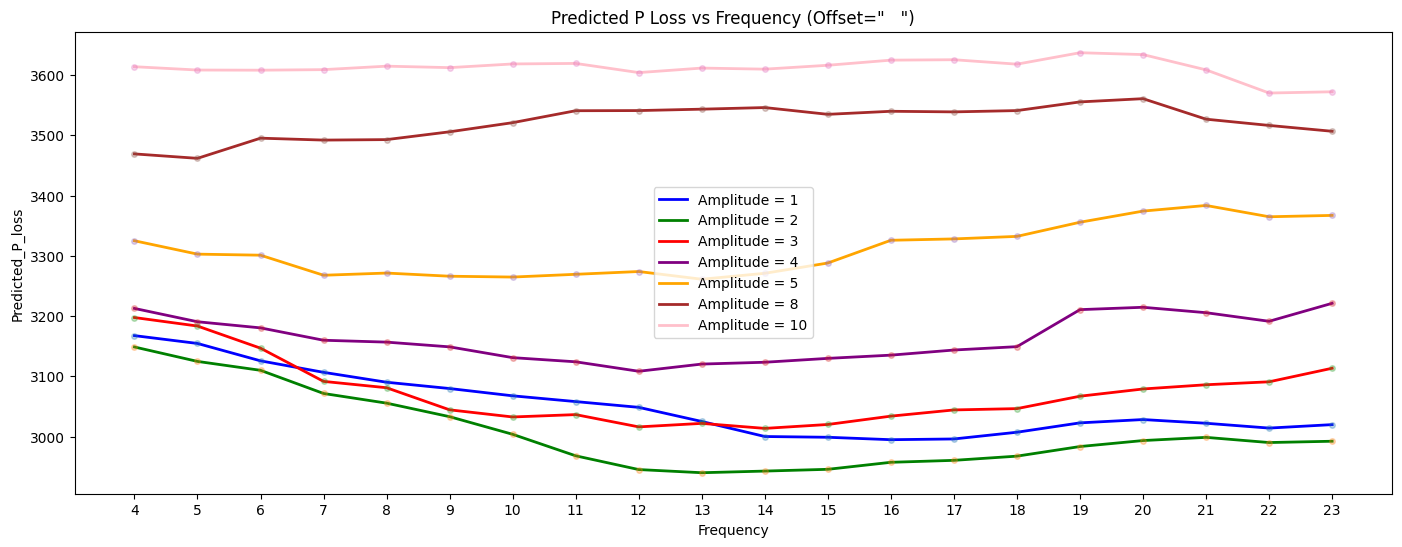

In [ ]:
import matplotlib.pyplot as plt

# Filter data for offset = -120
filtered_data = test_df_big_T[(test_df_big_T['Amplitude'].isin([1, 2, 3, 4, 5, 8, 10])) & (test_df_big_T['Offset'] == -80)
                                       & (test_df_big_T['InnRing'] == -1) & (test_df_big_T['OutRing'] == -1.5)]

# Group data by amplitude
grouped_data = filtered_data.groupby('Amplitude')

# Create the plot with desired characteristics
plt.figure(figsize=(17, 6))  # Adjust figure size for a wider plot

# Define specific colors for amplitudes 1 to 10
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

# Iterate through each group and plot with corresponding colors
for i, (amplitude, group_data) in enumerate(grouped_data):
    frequency = group_data['Frequency'].to_numpy()
    predicted_loss = group_data['Predicted_P_loss'].to_numpy()
    plt.plot(frequency, predicted_loss, label=f'Amplitude = {amplitude}', color=colors[i], linewidth=2)
    plt.plot(frequency, predicted_loss, 'o', markersize=4, alpha=0.3)

# Lighter markers for all lines

# Set labels, title, and xticks
plt.xlabel('Frequency')
plt.ylabel('Predicted_P_loss')
plt.title('Predicted P Loss vs Frequency (Offset="   ")')
plt.xticks(frequency)
plt.legend()

# Show the plot
plt.show()


3. (Frequncy and Offset trend) Frequncy trend at different offset, at single amplitude.

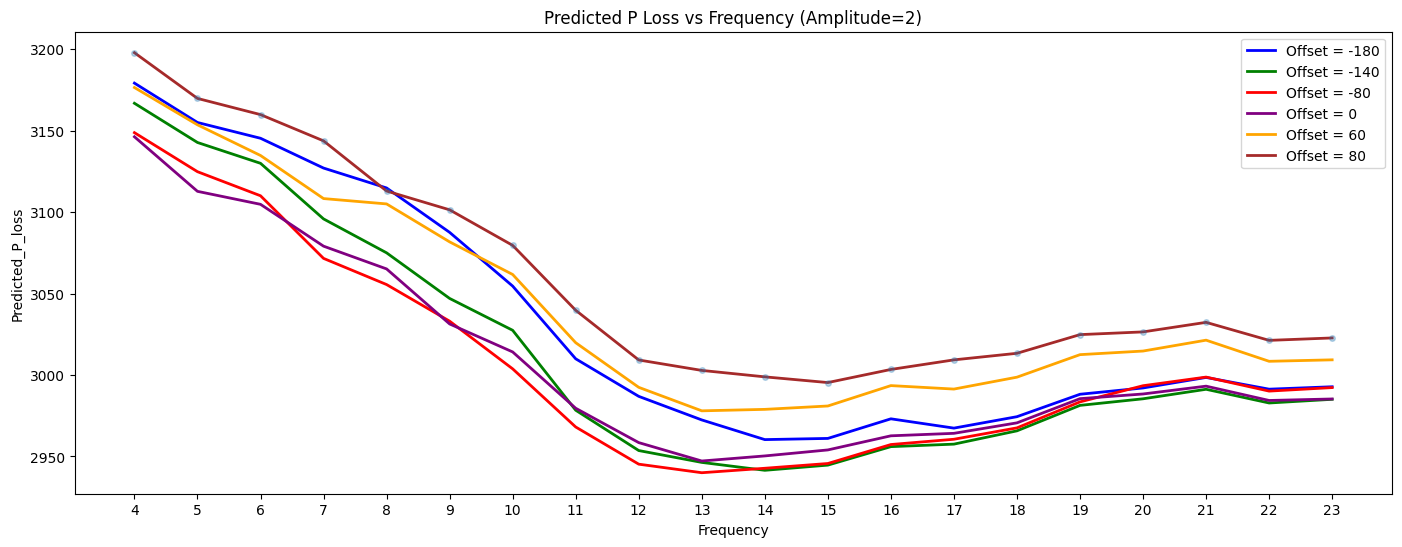

In [ ]:
import matplotlib.pyplot as plt

# Filter data for amplitude = 2 and desired offsets
filtered_data = test_df_big_T[(test_df_big_T['Amplitude'] == 2) & (test_df_big_T['Offset'].isin([-180,-140, -80, 0, 60, 80]))
                                                               & (test_df_big_T['InnRing'] == -1) & (test_df_big_T['OutRing'] == -1.5)]

# Group data by offset
grouped_data = filtered_data.groupby('Offset')

# Create the plot with desired characteristics
plt.figure(figsize=(17, 6))  # Adjust figure size as needed

# Define colors for the specific offsets (optionally use a colormap)
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray']

# Iterate through each offset group and plot with corresponding colors
for i, (offset, group_data) in enumerate(grouped_data):
    frequency = group_data['Frequency'].to_numpy()
    predicted_loss = group_data['Predicted_P_loss'].to_numpy()
    plt.plot(frequency, predicted_loss, label=f'Offset = {offset}', color=colors[i], linewidth=2)

# Lighter markers for all lines
plt.plot(frequency, predicted_loss, 'o', markersize=4, alpha=0.3)

# Set labels, title, and xticks
plt.xlabel('Frequency')
plt.ylabel('Predicted_P_loss')
plt.title('Predicted P Loss vs Frequency (Amplitude=2)')
plt.xticks(frequency)
plt.legend()  # Add legend to show offset values

# Show the plot
plt.show()
